# See through the fog: Curriculum learning (Implementing subsection 3.2)

In [ ]:
from google.colab import drive
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from random import randint
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2




In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

drive.mount('/content/gdrive')

data_dir = '/content/gdrive/MyDrive/Datasets/BrainTumorNew'

# Initialize ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) # normalize images and set a 20% validation split

# Load and preprocess the training dataset
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Resize all images to 224x224
    batch_size=32,
    class_mode='binary',
    subset='training')

# Load and preprocess the validation dataset
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation')

Mounted at /content/gdrive
Found 3011 images belonging to 2 classes.
Found 751 images belonging to 2 classes.


In [ ]:
# Occlusion function
'''def apply_occlusion(image, size=(20, 20)):
    h, w, _ = image.shape
    x = randint(0, w-size[0])
    y = randint(0, h-size[1])
    occluded = image.copy()
    occluded[y:y+size[1], x:x+size[0], :] = 0
    return occluded'''

# Switched to Occlusion only in the central 100*100 part of each image
'''def apply_occlusion(image, size=(10, 10)):
    h, w, _ = image.shape
    # Calculate the coordinates of the top-left corner of the central region
    x = w // 2 - size[0] // 2
    y = h // 2 - size[1] // 2
    occluded = image.copy()
    occluded[y:y+size[1], x:x+size[0], :] = 0
    return occluded
'''
# Checkerboard occlusion
'''def apply_occlusion(image, iteration):
    occluded = image.copy()
    h, w, _ = image.shape
    size = iteration  # Size of the checkerboard square, increasing with each iteration
    for i in range(0, h, size):
        for j in range(0, w, size):
            if (i // size + j // size) % 2 == 1:  # Condition for 'odd' checkerboard squares
                occluded[i:min(i+size, h), j:min(j+size, w), :] = 0
    return occluded'''


In [ ]:
def apply_occlusion(image, size=(50, 50)):
    h, w, _ = image.shape
    start_x = w // 2 - size[0] // 2
    start_y = h // 2 - size[1] // 2
    occluded = image.copy()
    occluded[start_y:start_y+size[1], start_x:start_x+size[0], :] = 0
    return occluded


In [ ]:
def occlusion_generator(base_generator, occlusion_size):
    while True:
        batch_x, batch_y = next(base_generator)
        batch_x = np.array([apply_occlusion(img, occlusion_size) for img in batch_x])
        yield (batch_x, batch_y)


In [ ]:
# Runnning on raw images first
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(train_generator, epochs=5, validation_data=validation_generator, callbacks=[reduce_lr])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Epoch 1/5
19/95 [=====>........................] - ETA: 34:00 - loss: 5.7729 - accuracy: 0.7220

In [ ]:
T = 4
for t in range(T):
    occlusion_size = (5 + 2 * t, 5 + 2 * t)

    # Create a new occlusion generator for each step
    train_occlusion_generator = occlusion_generator(train_generator, occlusion_size)

    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Learning rate reduction on plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

    history = model.fit(train_occlusion_generator, epochs=5, validation_data=validation_generator, callbacks=[reduce_lr])

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


In [ ]:
# Directly starts with occluded data

T = 4
steps_per_epoch = train_generator.samples // train_generator.batch_size

for t in range(T):
    occlusion_size = (5 + 2 * t, 5 + 2 * t)

    # Create a new occlusion generator for each step
    train_occlusion_generator = occlusion_generator(train_generator, occlusion_size, steps_per_epoch)

    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Learning rate reduction on plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

    history = model.fit(train_occlusion_generator,
                        steps_per_epoch=steps_per_epoch,
                        epochs=5,
                        validation_data=validation_generator,
                        callbacks=[reduce_lr])

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


# Refined implementation -  using openCV. The homemade occlusion functions were lagging badly. Moreover ResNet (71 mins ETA) is too big for us (we are poor people!). So, resorted to MobileNet (4 mins ETA). But MobileNetV2 is too simple overall for this work. We will have to bring back heavy duty models eventually.

In [ ]:
from google.colab import drive
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
#from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from random import randint
import matplotlib.pyplot as plt
from tensorflow.keras.applications import (ResNet50, VGG16, InceptionV3, MobileNetV2, DenseNet121)




In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

drive.mount('/content/gdrive')

data_dir = '/content/gdrive/MyDrive/Datasets/BrainTumorNew'

# Initialize ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) # normalize images and set a 20% validation split

# Load and preprocess the training dataset
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Resize all images to 224x224
    batch_size=32,
    class_mode='binary',
    subset='training')

# Load and preprocess the validation dataset
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation')#

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Found 3011 images belonging to 2 classes.
Found 751 images belonging to 2 classes.


In [ ]:
import cv2
import numpy as np

def apply_occlusion(image, size=(50, 50)):
    h, w, _ = image.shape
    start_x = w // 2 - size[0] // 2
    start_y = h // 2 - size[1] // 2
    occluded = image.copy()
    cv2.rectangle(occluded, (start_x, start_y), (start_x + size[0], start_y + size[1]), (0, 0, 0), -1)
    return occluded


In [ ]:
def occlusion_generator(base_generator, occlusion_size, steps_per_epoch):
    i = 0
    while True:
        if i >= steps_per_epoch:
            i = 0
        batch_x, batch_y = base_generator[i]
        batch_x = np.array([apply_occlusion(img, occlusion_size) for img in batch_x])
        i += 1
        yield (batch_x, batch_y)


In [ ]:
# Define the model before the loop
steps_per_epoch = train_generator.samples // train_generator.batch_size

base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train on the actual dataset first
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=5,
                    validation_data=validation_generator,
                    callbacks=[reduce_lr])

# Plot initial training accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

T = 4
# Then continue training on the occluded data
for t in range(T):
    occlusion_size = (5 + 2 * t, 5 + 2 * t)

    # Create a new occlusion generator for each step
    train_occlusion_generator = occlusion_generator(train_generator, occlusion_size, steps_per_epoch)

    history = model.fit(train_occlusion_generator,
                        steps_per_epoch=steps_per_epoch,
                        epochs=5,
                        validation_data=validation_generator,
                        callbacks=[reduce_lr])

    # Plot training accuracy after each occlusion iteration
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - Occlusion iteration {t+1}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


# Wasserstein Strategy

In [1]:
import cv2
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Concatenate, GlobalAveragePooling2D
from scipy.stats import wasserstein_distance
from tensorflow.keras.preprocessing.image import ImageDataGenerator

drive.mount('/content/gdrive')

data_dir = '/content/gdrive/MyDrive/Datasets/new_HAM_binary_dummy'

# Initialize ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training')

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation')



Mounted at /content/gdrive
Found 116 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


Epoch 1/5
3/3 [==============================] - 75s 11s/step - loss: 0.7078 - accuracy: 0.5833 - val_loss: 0.7858 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 2/5
3/3 [==============================] - 26s 9s/step - loss: 0.2028 - accuracy: 0.8958 - val_loss: 2.1848 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 3/5
3/3 [==============================] - 22s 8s/step - loss: 0.0869 - accuracy: 1.0000 - val_loss: 3.7363 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 4/5
3/3 [==============================] - 24s 8s/step - loss: 0.0788 - accuracy: 1.0000 - val_loss: 5.7142 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 5/5
3/3 [==============================] - 23s 8s/step - loss: 0.0558 - accuracy: 1.0000 - val_loss: 7.6038 - val_accuracy: 0.4167 - lr: 0.0010


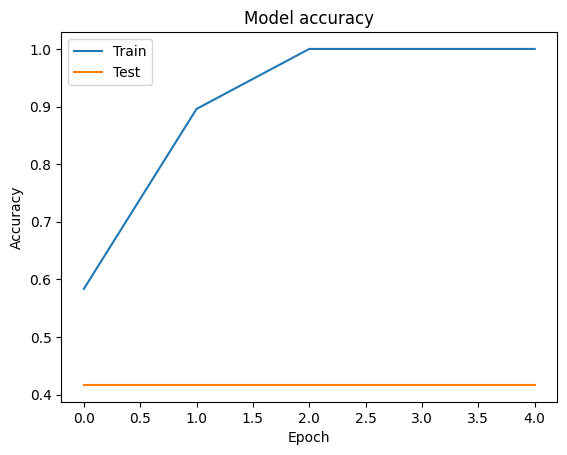

Epoch 1/5
3/3 [==============================] - 49s 11s/step - loss: 443.1089 - accuracy: 0.7188 - val_loss: 443.6112 - val_accuracy: 0.5417 - lr: 0.0010
Epoch 2/5
3/3 [==============================] - 25s 9s/step - loss: 442.6206 - accuracy: 0.9375 - val_loss: 444.1613 - val_accuracy: 0.5417 - lr: 0.0010
Epoch 3/5
3/3 [==============================] - 24s 8s/step - loss: 442.5314 - accuracy: 0.9896 - val_loss: 444.7476 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 4/5
3/3 [==============================] - 24s 9s/step - loss: 442.5066 - accuracy: 0.9896 - val_loss: 445.0951 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 5/5
3/3 [==============================] - 23s 8s/step - loss: 442.4849 - accuracy: 1.0000 - val_loss: 445.3297 - val_accuracy: 0.4167 - lr: 0.0010


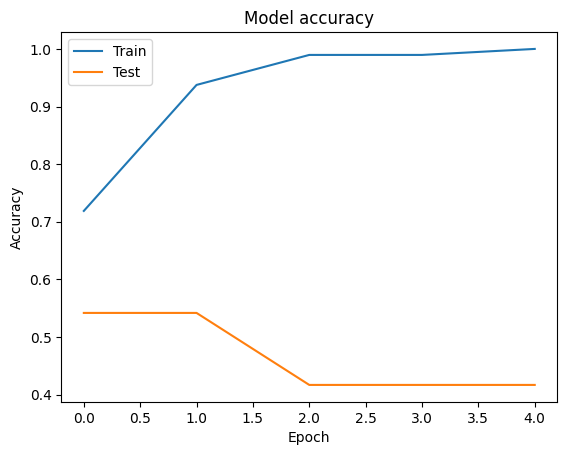

Epoch 1/5
3/3 [==============================] - 46s 9s/step - loss: 684.1907 - accuracy: 0.6667 - val_loss: 684.1492 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 2/5
3/3 [==============================] - 31s 12s/step - loss: 683.7964 - accuracy: 0.8333 - val_loss: 683.8472 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 3/5
3/3 [==============================] - 27s 9s/step - loss: 683.5903 - accuracy: 0.9583 - val_loss: 683.8864 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 4/5
3/3 [==============================] - 22s 8s/step - loss: 683.5544 - accuracy: 0.9896 - val_loss: 683.9528 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 5/5
3/3 [==============================] - 24s 8s/step - loss: 683.5633 - accuracy: 0.9688 - val_loss: 683.9818 - val_accuracy: 0.6667 - lr: 0.0010


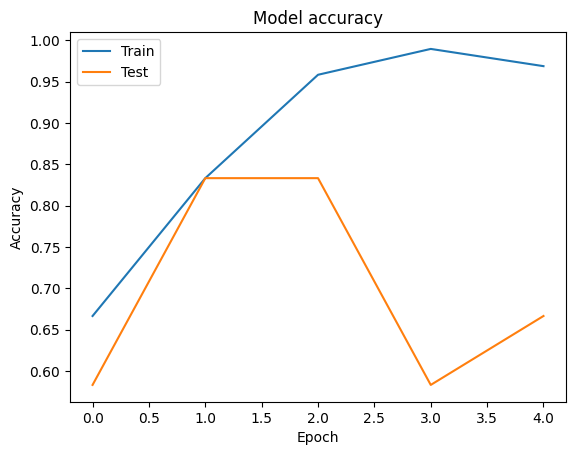

Epoch 1/5
3/3 [==============================] - 44s 9s/step - loss: 4516.4336 - accuracy: 0.7500 - val_loss: 4516.7754 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 2/5
3/3 [==============================] - 24s 8s/step - loss: 4516.0527 - accuracy: 0.9271 - val_loss: 4516.7207 - val_accuracy: 0.5417 - lr: 0.0010
Epoch 3/5
3/3 [==============================] - 23s 8s/step - loss: 4515.9570 - accuracy: 0.9792 - val_loss: 4517.5469 - val_accuracy: 0.5417 - lr: 0.0010
Epoch 4/5
3/3 [==============================] - 22s 8s/step - loss: 4515.9224 - accuracy: 1.0000 - val_loss: 4518.3745 - val_accuracy: 0.5417 - lr: 0.0010
Epoch 5/5
3/3 [==============================] - 24s 8s/step - loss: 4515.8848 - accuracy: 1.0000 - val_loss: 4518.9453 - val_accuracy: 0.4167 - lr: 0.0010


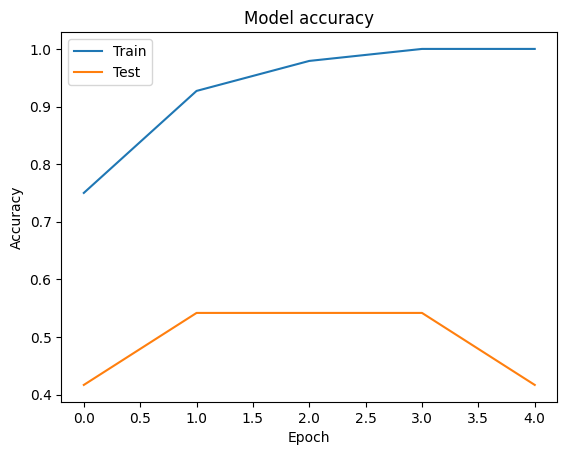

In [ ]:
def apply_occlusion(image, size=(50, 50)):
    h, w, _ = image.shape
    start_x = w // 2 - size[0] // 2
    start_y = h // 2 - size[1] // 2
    occluded = image.copy()
    cv2.rectangle(occluded, (start_x, start_y), (start_x + size[0], start_y + size[1]), (0, 0, 0), -1)
    return occluded

def occlusion_generator(base_generator, occlusion_size, steps_per_epoch):
    i = 0
    while True:
        if i >= steps_per_epoch:
            i = 0
        batch_x, batch_y = base_generator[i]
        batch_x = np.array([apply_occlusion(img, occlusion_size) for img in batch_x])
        i += 1
        yield (batch_x, batch_y)

# Loss functions
def wasserstein_loss(y_true, y_pred):
    return K.sum(wasserstein_distance(y_true, y_pred))

def model_loss(y_true, y_pred, occlusion_distance):
    return BinaryCrossentropy()(y_true, y_pred) + lambda_ * occlusion_distance

# Main
T = 4
steps_per_epoch = train_generator.samples // train_generator.batch_size
occlusion_distance = K.variable(value=0.0)
lambda_ = 0.01
prev_occlusion_histogram = None

for t in range(T):
    occlusion_size = (5 + 2 * t, 5 + 2 * t)
    train_occlusion_generator = occlusion_generator(train_generator, occlusion_size, steps_per_epoch)

    #occlusion_histogram = np.histogram([apply_occlusion(img, occlusion_size) for img in train_generator.next()[0]])
    #occlusion_histogram, _ = np.histogram([apply_occlusion(img, occlusion_size).sum() for img in train_generator.next()[0]])
    #update1

    occlusion_histogram, _ = np.histogram([apply_occlusion(img, occlusion_size) for img in train_generator.next()[0]], bins=10, range=(0,1))  # Added bins and range


    if prev_occlusion_histogram is not None:
        #K.set_value(occlusion_distance, wasserstein_loss(prev_occlusion_histogram, occlusion_histogram))
        #update2
        K.set_value(occlusion_distance, wasserstein_distance(prev_occlusion_histogram, occlusion_histogram))  # Used scipy's wasserstein_distance





    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    dropout_1 = layers.Dropout(0.4)(base_model.output)
    global_average_layer = layers.GlobalAveragePooling2D()(dropout_1)
    flatten_layer = layers.Flatten()(global_average_layer)
    dropout_2 = layers.Dropout(0.4)(flatten_layer)
    dense_1 = layers.Dense(512, activation='relu')(dropout_2)
    batchnorm_1 = BatchNormalization()(dense_1)  # Batch Normalization layer after Dense layer
    dropout_3 = layers.Dropout(0.4)(batchnorm_1)
    dense_2 = layers.Dense(128, activation='relu')(dropout_3)
    batchnorm_2 = BatchNormalization()(dense_2)  # Batch Normalization layer after Dense layer

    # included a forward connection to one back from penultimate layer in the top that skips the inner layers
    concatenate = Concatenate()([flatten_layer, batchnorm_2])

    dropout_4 = layers.Dropout(0.4)(concatenate)
    dense_3 = layers.Dense(32, activation='relu')(dropout_4)
    batchnorm_3 = BatchNormalization()(dense_3)  # Batch Normalization layer after Dense layer

    dropout_5 = layers.Dropout(0.4)(batchnorm_3)

    output_tensor = layers.Dense(1, activation='sigmoid')(dropout_5)

    # create the functional model
    model = Model(base_model.inputs, output_tensor)
    model.compile(optimizer=Adam(), loss=lambda y_true, y_pred: model_loss(y_true, y_pred, occlusion_distance), metrics=['accuracy'])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

    history = model.fit(train_occlusion_generator,
                        steps_per_epoch=steps_per_epoch,
                        epochs=5,
                        validation_data=validation_generator,
                        callbacks=[reduce_lr])

    prev_occlusion_histogram = occlusion_histogram

    # Plot training accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()



# Hollow Wasserstein (Plz don't panic, dummy data of 100 images is used)

Epoch 1/5
3/3 [==============================] - ETA: 0s - loss: 0.6290 - accuracy: 0.6875 - precision: 0.7547 - recall: 0.7018 - auc: 0.7440
Epoch 1: val_loss improved from inf to 0.49930, saving model to MobV2Wasserrand.h5
3/3 [==============================] - 59s 11s/step - loss: 0.6290 - accuracy: 0.6875 - precision: 0.7547 - recall: 0.7018 - auc: 0.7440 - val_loss: 0.4993 - val_accuracy: 0.7917 - val_precision: 1.0000 - val_recall: 0.6429 - val_auc: 0.9714 - lr: 0.0010
Epoch 2/5
3/3 [==============================] - ETA: 0s - loss: 0.1942 - accuracy: 0.9583 - precision: 1.0000 - recall: 0.9298 - auc: 0.9919
Epoch 2: val_loss improved from 0.49930 to 0.48680, saving model to MobV2Wasserrand.h5
3/3 [==============================] - 24s 9s/step - loss: 0.1942 - accuracy: 0.9583 - precision: 1.0000 - recall: 0.9298 - auc: 0.9919 - val_loss: 0.4868 - val_accuracy: 0.7917 - val_precision: 1.0000 - val_recall: 0.6429 - val_auc: 0.9714 - lr: 0.0010
Epoch 3/5
3/3 [======================

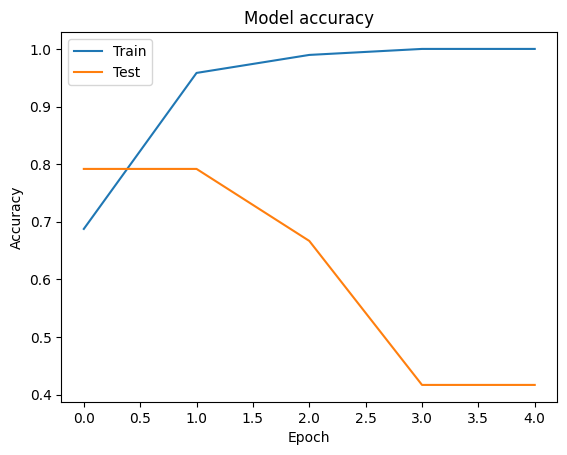

Epoch 1/5
3/3 [==============================] - ETA: 0s - loss: 451.6136 - accuracy: 0.6146 - precision_1: 0.6923 - recall_1: 0.6316 - auc_1: 0.6896
Epoch 1: val_loss improved from inf to 452.46484, saving model to MobV2Wasserrand.h5
3/3 [==============================] - 47s 11s/step - loss: 451.6136 - accuracy: 0.6146 - precision_1: 0.6923 - recall_1: 0.6316 - auc_1: 0.6896 - val_loss: 452.4648 - val_accuracy: 0.4167 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_auc_1: 0.5143 - lr: 0.0010
Epoch 2/5
3/3 [==============================] - ETA: 0s - loss: 451.0030 - accuracy: 0.9583 - precision_1: 1.0000 - recall_1: 0.9298 - auc_1: 0.9960
Epoch 2: val_loss did not improve from 452.46484
3/3 [==============================] - 31s 9s/step - loss: 451.0030 - accuracy: 0.9583 - precision_1: 1.0000 - recall_1: 0.9298 - auc_1: 0.9960 - val_loss: 454.8092 - val_accuracy: 0.4167 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_auc_1: 0.6786 - lr: 0.0010
Epoch 3/5

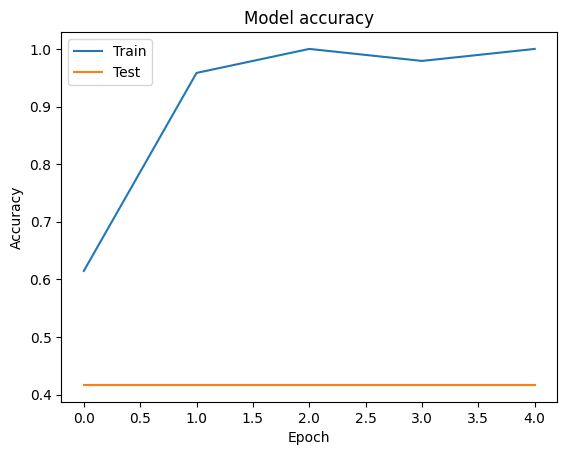

Epoch 1/5
3/3 [==============================] - ETA: 0s - loss: 4516.6167 - accuracy: 0.6354 - precision_2: 0.7037 - recall_2: 0.6667 - auc_2: 0.6482
Epoch 1: val_loss improved from inf to 4516.33936, saving model to MobV2Wasserrand.h5
3/3 [==============================] - 46s 9s/step - loss: 4516.6167 - accuracy: 0.6354 - precision_2: 0.7037 - recall_2: 0.6667 - auc_2: 0.6482 - val_loss: 4516.3394 - val_accuracy: 0.8750 - val_precision_2: 1.0000 - val_recall_2: 0.7857 - val_auc_2: 0.9571 - lr: 0.0010
Epoch 2/5
3/3 [==============================] - ETA: 0s - loss: 4516.0063 - accuracy: 0.9688 - precision_2: 0.9821 - recall_2: 0.9649 - auc_2: 0.9978
Epoch 2: val_loss improved from 4516.33936 to 4516.21045, saving model to MobV2Wasserrand.h5
3/3 [==============================] - 24s 8s/step - loss: 4516.0063 - accuracy: 0.9688 - precision_2: 0.9821 - recall_2: 0.9649 - auc_2: 0.9978 - val_loss: 4516.2104 - val_accuracy: 0.7917 - val_precision_2: 0.8462 - val_recall_2: 0.7857 - val_au

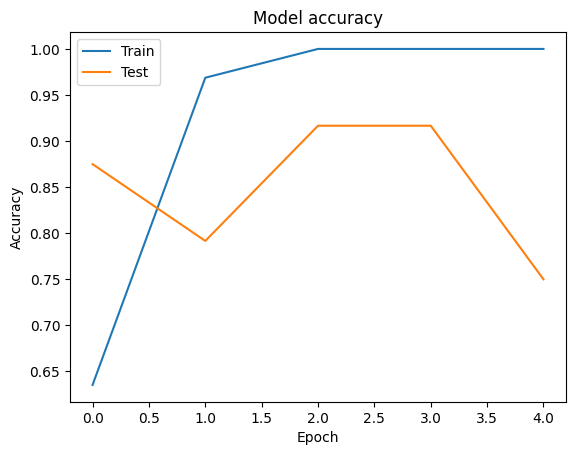

Epoch 1/5
3/3 [==============================] - ETA: 0s - loss: 4516.4590 - accuracy: 0.6771 - precision_3: 0.7451 - recall_3: 0.6786 - auc_3: 0.7607
Epoch 1: val_loss improved from inf to 4516.46777, saving model to MobV2Wasserrand.h5
3/3 [==============================] - 48s 10s/step - loss: 4516.4590 - accuracy: 0.6771 - precision_3: 0.7451 - recall_3: 0.6786 - auc_3: 0.7607 - val_loss: 4516.4678 - val_accuracy: 0.5417 - val_precision_3: 0.5789 - val_recall_3: 0.7857 - val_auc_3: 0.6429 - lr: 0.0010
Epoch 2/5
3/3 [==============================] - ETA: 0s - loss: 4516.0005 - accuracy: 0.9688 - precision_3: 0.9818 - recall_3: 0.9643 - auc_3: 0.9953
Epoch 2: val_loss improved from 4516.46777 to 4516.39014, saving model to MobV2Wasserrand.h5
3/3 [==============================] - 22s 8s/step - loss: 4516.0005 - accuracy: 0.9688 - precision_3: 0.9818 - recall_3: 0.9643 - auc_3: 0.9953 - val_loss: 4516.3901 - val_accuracy: 0.7917 - val_precision_3: 1.0000 - val_recall_3: 0.6429 - val_a

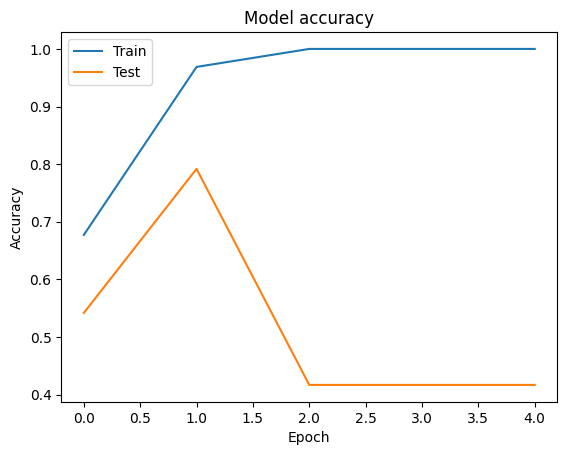

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from random import randint
import tensorflow as tf


def apply_occlusion(image, size=(20, 20), border_thickness=2):
    h, w, _ = image.shape
    x = randint(0, w - size[0])
    y = randint(0, h - size[1])
    occluded = image.copy()
    cv2.rectangle(occluded, (x, y), (x + size[0], y + size[1]), (0, 0, 0), border_thickness)
    return occluded

def occlusion_generator(base_generator, occlusion_size, steps_per_epoch):
    i = 0
    while True:
        if i >= steps_per_epoch:
            i = 0
        batch_x, batch_y = base_generator[i]
        batch_x = np.array([apply_occlusion(img, occlusion_size) for img in batch_x])
        i += 1
        yield (batch_x, batch_y)

# Loss functions
def wasserstein_loss(y_true, y_pred):
    return K.sum(wasserstein_distance(y_true, y_pred))

def model_loss(y_true, y_pred, occlusion_distance):
    return BinaryCrossentropy()(y_true, y_pred) + lambda_ * occlusion_distance

# Main
T = 4
steps_per_epoch = train_generator.samples // train_generator.batch_size
occlusion_distance = K.variable(value=0.0)
lambda_ = 0.01
prev_occlusion_histogram = None

for t in range(T):
    occlusion_size = (5 + 2 * t, 5 + 2 * t)
    train_occlusion_generator = occlusion_generator(train_generator, occlusion_size, steps_per_epoch)

    occlusion_histogram, _ = np.histogram([apply_occlusion(img, occlusion_size) for img in train_generator.next()[0]], bins=10, range=(0,1))

    if prev_occlusion_histogram is not None:
        K.set_value(occlusion_distance, wasserstein_distance(prev_occlusion_histogram, occlusion_histogram))

    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    dropout_1 = layers.Dropout(0.4)(base_model.output)
    global_average_layer = layers.GlobalAveragePooling2D()(dropout_1)
    flatten_layer = layers.Flatten()(global_average_layer)
    dropout_2 = layers.Dropout(0.4)(flatten_layer)
    dense_1 = layers.Dense(512, activation='relu')(dropout_2)
    batchnorm_1 = BatchNormalization()(dense_1)
    dropout_3 = layers.Dropout(0.4)(batchnorm_1)
    dense_2 = layers.Dense(128, activation='relu')(dropout_3)
    batchnorm_2 = BatchNormalization()(dense_2)

    concatenate = Concatenate()([flatten_layer, batchnorm_2])
    dropout_4 = layers.Dropout(0.4)(concatenate)
    dense_3 = layers.Dense(32, activation='relu')(dropout_4)
    batchnorm_3 = BatchNormalization()(dense_3)
    dropout_5 = layers.Dropout(0.4)(batchnorm_3)

    output_tensor = layers.Dense(1, activation='sigmoid')(dropout_5)
    model = Model(base_model.inputs, output_tensor)

    model.compile(optimizer=Adam(), loss=lambda y_true, y_pred: model_loss(y_true, y_pred, occlusion_distance), metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])
    model_name = "MobV2Wasserrand.h5"
    checkpoint = ModelCheckpoint(model_name,
                                monitor="val_loss",
                                mode="min",
                                save_best_only = True,
                                verbose=1)

    earlystopping = EarlyStopping(monitor='val_loss', min_delta = 0, patience = 15, verbose = 1, restore_best_weights=True)

    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                                patience=3,
                                                verbose=1,
                                                factor=0.3,
                                                min_lr=0.00000001)

    history = model.fit(train_occlusion_generator,
                        steps_per_epoch=steps_per_epoch,
                        epochs=5,
                        validation_data=validation_generator,
                        callbacks=[checkpoint, earlystopping, learning_rate_reduction])

    prev_occlusion_histogram = occlusion_histogram

    # Plot training accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


# Code for generating rep. of progressive occlusions

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


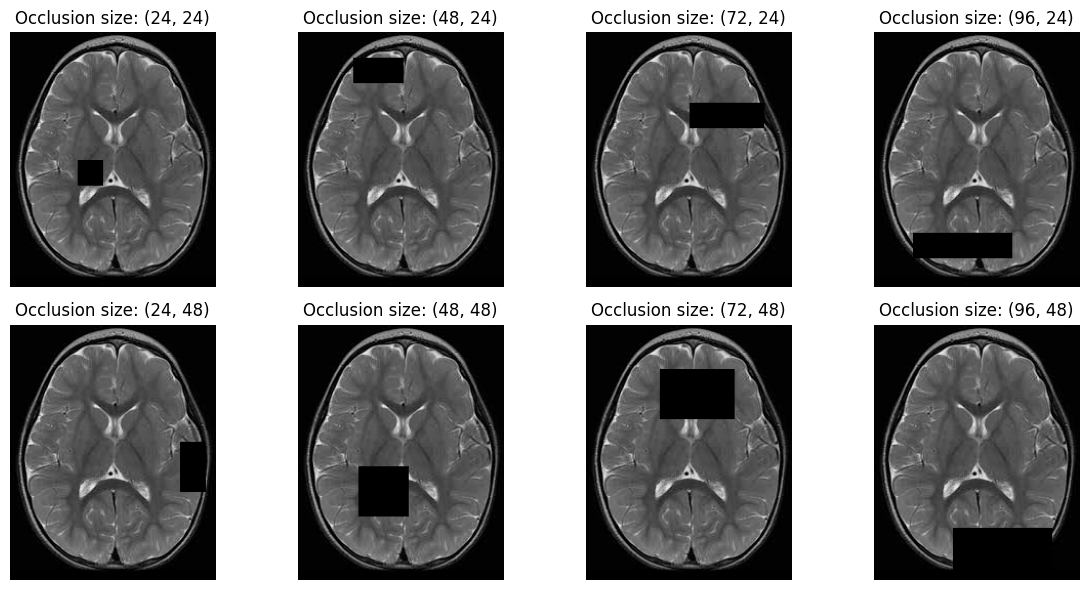

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from random import randint
from google.colab import drive

drive.mount('/content/gdrive')



image = cv2.imread('/content/gdrive/MyDrive/Datasets/sample.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def apply_occlusion(image, size=(50, 50)):
    h, w, _ = image.shape
    start_x = randint(0, w-size[0])
    start_y = randint(0, h-size[1])
    occluded = image.copy()
    cv2.rectangle(occluded, (start_x, start_y), (start_x + size[0], start_y + size[1]), (0, 0, 0), -1)
    return occluded

fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i in range(2):
    for j in range(4):
        occlusion_size = (24 * (j + 1), 24 * (i + 1))
        ax[i, j].imshow(apply_occlusion(image, occlusion_size))
        ax[i, j].set_title(f'Occlusion size: {occlusion_size}')
        ax[i, j].axis('off')

plt.tight_layout()
plt.show()


# New Model with fusion of VGG and ResNet

In [11]:
import cv2
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Concatenate, GlobalAveragePooling2D
from scipy.stats import wasserstein_distance
from tensorflow.keras.preprocessing.image import ImageDataGenerator

drive.mount('/content/gdrive')

data_dir = '/content/gdrive/MyDrive/Datasets/new_HAM_binary'

# Initialize ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training')

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Found 6434 images belonging to 2 classes.
Found 1607 images belonging to 2 classes.


In [12]:
from keras.applications import VGG16, ResNet50
from keras.layers import Dense, Concatenate, Flatten, Dropout, BatchNormalization, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam

# Define the shared input layer
input_layer = Input(shape=(224, 224, 3))

# Load the base models
vgg_base = VGG16(weights='imagenet', include_top=False)
resnet_base = ResNet50(weights='imagenet', include_top=False)

for layer in vgg_base.layers:
    layer.trainable = False

for layer in resnet_base.layers:
    layer.trainable = False

# Use the base models on the input layer
base_model1 = vgg_base(input_layer)
base_model2 = resnet_base(input_layer)

# Flatten the output of the models
model1 = Flatten()(base_model1)
model2 = Flatten()(base_model2)

# Concatenate the outputs of the two models
merged = Concatenate()([model1, model2])

# Add a dense layer and then a normalization layer and a dropout layer, and finally the classification layer
merged = Dense(256, activation='relu')(merged)
merged = BatchNormalization()(merged)
merged = Dropout(0.5)(merged)
predictions = Dense(1, activation='sigmoid')(merged)  # Assuming binary classification

final_model = Model(inputs=input_layer, outputs=predictions)

final_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.2,
                              patience=5, min_lr=0.001)

history = final_model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // 32,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // 32,
    epochs = 25,
    callbacks=[reduce_lr])


Epoch 1/25
 22/201 [==>...........................] - ETA: 1:25:42 - loss: 0.3855 - accuracy: 0.8324

KeyboardInterrupt: ignored